In [156]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define Classes

In [157]:
class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "Add",
    "Decimal",
    "Division",
    "Equals",
    "Multiply",
    "Minus",
    "X",
    "Y",
    "Z",
]

# Load Model

In [158]:

model = tf.keras.models.load_model("models/19_class.h5")

# Helper Function

In [159]:
def show_img(img):
    plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)
    
    
def show_images(images, title=''):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(330 + 1 + i)
        plt.imshow(image)
        plt.title(title)
    
    
def show_prediction(image):
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')/255

    predictions = model.predict(image)
    label = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)*100
    return label,confidence

# Run inference on single image 

In [160]:
# img_path = '/home/sagyam/Desktop/x.png'
# image = cv.imread(img_path)

# label, confidence = show_prediction(image)

# Experiment with image segmentation

#

In [161]:
img_path = '/home/sagyam/Desktop/test.png'
image = cv.imread(img_path)

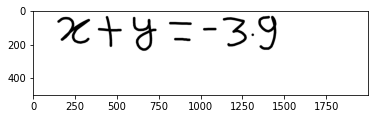

In [162]:
show_img(image)

# Do some preprocessing

In [163]:
gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
edged = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 11, 4)
(contours, _) = cv.findContours(edged, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

# Find Bounding box using Contours 

In [164]:
chars_bb = []
for contour in contours:
            contour = contour.reshape((contour.shape[0],contour.shape[2]))
            left_tc = np.amin(contour, axis=0)
            right_bc = np.amax(contour, axis=0)
            min_x = left_tc[0]
            max_x = right_bc[0]
            min_y = left_tc[1]
            max_y = right_bc[1]
            chars_bb.append([min_x,min_y,max_x,max_y])

# Show bounding box

[842, 160, 940, 178]
[1304, 134, 1319, 148]
[1015, 100, 1095, 115]
[812, 65, 947, 82]
[1133, 37, 1276, 210]
[596, 35, 737, 236]
[145, 35, 340, 194]
[387, 30, 529, 213]
[1345, 29, 1453, 230]


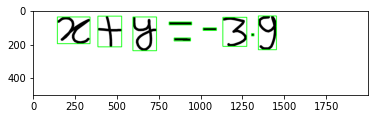

In [165]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),3)
    print(box)
    
show_img(copy)

As we can see = (equals) is detected as double -(minus)

# Replacing Double Minus as EqualsTo

First we sort boxes based on first value (ie x_min)

In [166]:
chars_bb.sort()
chars_bb

[[145, 35, 340, 194],
 [387, 30, 529, 213],
 [596, 35, 737, 236],
 [812, 65, 947, 82],
 [842, 160, 940, 178],
 [1015, 100, 1095, 115],
 [1133, 37, 1276, 210],
 [1304, 134, 1319, 148],
 [1345, 29, 1453, 230]]

# Logic for replacing double minus with equals

Note even though this logic should repalce most double minus with
equals to we still need further logic to explicitly convert two 
consecutive minus as equals

In [167]:
for i, box in enumerate(chars_bb):
    try:
         next_box = chars_bb[i+1]
    except IndexError:
        break
   
    if abs(box[0] - next_box[0]) <= 30:
        min_x = min(box[0],next_box[0])
        min_y = min(box[1],next_box[1])
        max_x = max(box[2],next_box[2])
        max_y = max(box[3],next_box[3])
        new_box = [min_x,min_y,max_x,max_y]
        chars_bb[i] = new_box
        chars_bb.remove(next_box)
        
        

[145, 35, 340, 194]
[387, 30, 529, 213]
[596, 35, 737, 236]
[812, 65, 947, 178]
[1015, 100, 1095, 115]
[1133, 37, 1276, 210]
[1304, 134, 1319, 148]
[1345, 29, 1453, 230]


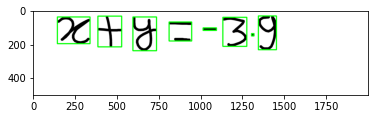

In [168]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),5)
    print(box)
    
show_img(copy)

# Crop the images and get predictions

In [169]:
croped_images = []
copy = image.copy()
for box in chars_bb:
    x_min = box[0]
    y_min = box[1]
    height = abs(box[0]-box[2])
    width = abs(box[1]-box[3])
    character = copy[y_min:y_min+width , x_min:x_min+height]
    croped_images.append(character)
    

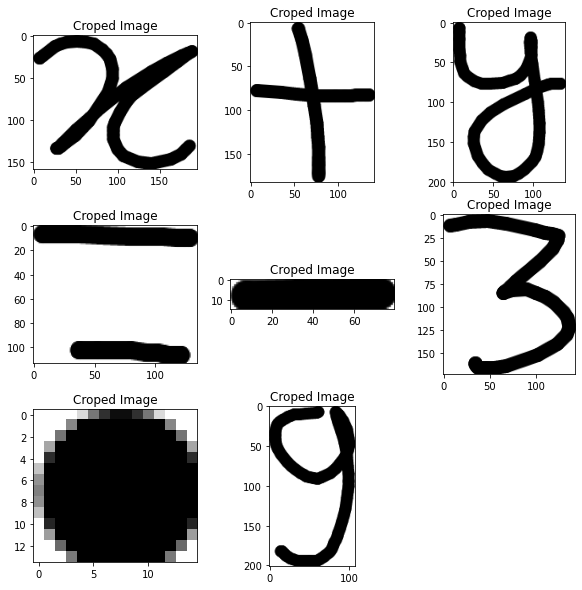

In [170]:
show_images(croped_images, title='Croped Image')

Notice how zoomed in the cropped image is!! 
Our model is not used to seeing images this up close so it may not able to classify images correctly if we feed this image direclty.
We need to apply some padding to this image so the image resemble someting in the traning dataset 

# Pad and resize images
extra_padding() method adds 50px padding to all sides of an image 

In [171]:
def extra_padding(img, padding=50):
    return cv.copyMakeBorder(img, top=padding, bottom=padding, left=padding, right=padding, borderType=cv.BORDER_CONSTANT, value=(255,255,255))

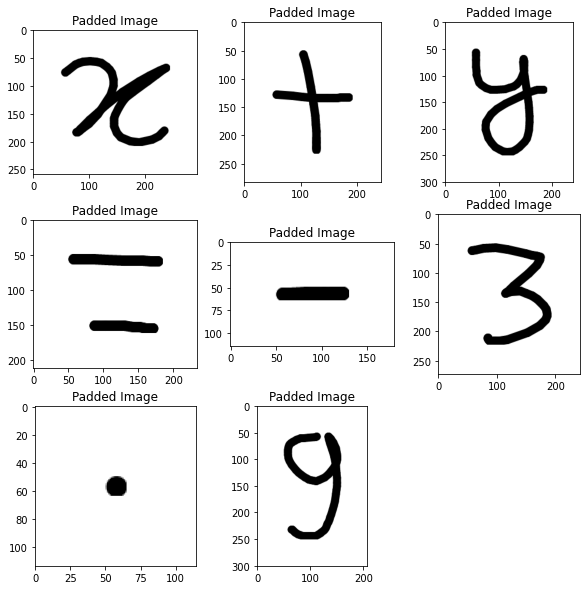

In [172]:
padded_images = []
for img in croped_images:
    padded_img = extra_padding(img)
    padded_images.append(padded_img)

show_images(padded_images, title='Padded Image')

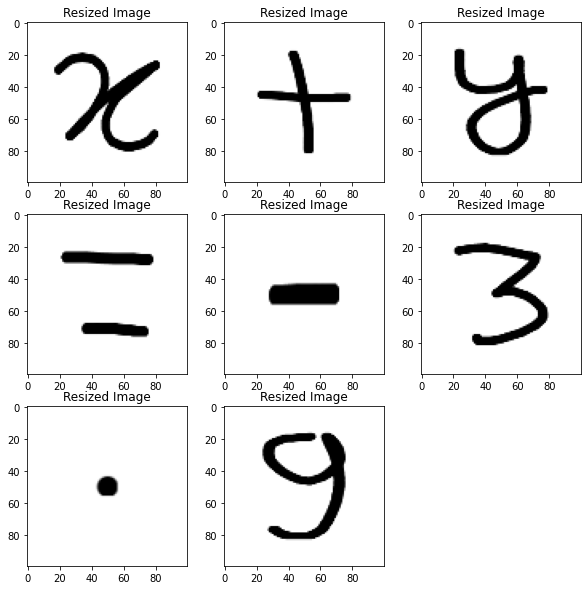

In [173]:
resized_images = []
for img in padded_images:
    resized_img = cv.resize(img, (100, 100), interpolation=cv.INTER_LINEAR)
    resized_images.append(resized_img)

show_images(resized_images, title='Resized Image')

Now lets run inference on each image and see the output

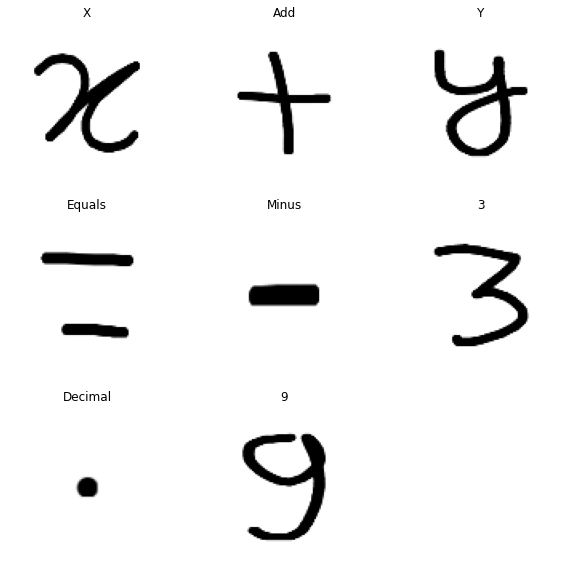

In [174]:
plt.figure(figsize=(10, 10))
for i, image in enumerate(resized_images):
    label, conf = show_prediction(image)
    plt.subplot(330 + 1 + i)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")